In [1]:
import torch
import numpy as np

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device('cuda')

In [ ]:
!unzip -q /content/drive/MyDrive/DataScience/journey-springfield.zip "testset/*" "train/*"

In [ ]:
from matplotlib.backend_bases import ResizeEvent
from torchvision.transforms.transforms import Resize

class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f'{self.mode} is not correct; correct modes: {DATA_MODES}')
            raise NameError

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return len(self.files)

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        data_transforms = {
            'train': transforms.Compose([
                     transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                     transforms.RandomRotation(degrees=30),
                     transforms.RandomHorizontalFlip(),
                     #transforms.RandomVerticalFlip(),
                     transforms.ColorJitter(hue=.03, saturation=.03),
                     transforms.ToTensor(),
                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                        
                ]),
            'test': transforms.Compose([
                    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
        }

        transform = (data_transforms['train'] if self.mode == 'train' else data_transforms['test'])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
len(train_val_files), len(test_files)

(20933, 991)

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

train_labels = [path.parent.name for path in train_files]
test_train_files, test_eval_files = train_test_split(train_files, test_size=0.25, stratify=train_labels)

#test_eval_lb = [path.parent.name for path in val_files]
#test_eval, _ = train_test_split(val_files, test_size=0.55, stratify=test_eval_lb)

In [ ]:
len(train_val_files), len(train_files), len(val_files), len(test_train_files), len(test_eval_files)

(20933, 15699, 5234, 11774, 3925)

In [ ]:
import random
import glob
from collections import Counter

counted_files_per_dir = Counter([path.parent for path in train_files])
low_sampled_class = {key: value for key, value in counted_files_per_dir.items() if value < 30}

for key, val in low_sampled_class.items():
    for _ in range(30 - val):
        train_files.append(random.choice(list(key.glob('**/*.jpg'))))
train_files.sort()
Counter([path.parent for path in train_files])

Counter({PosixPath('train/simpsons_dataset/abraham_grampa_simpson'): 685,
         PosixPath('train/simpsons_dataset/agnes_skinner'): 32,
         PosixPath('train/simpsons_dataset/apu_nahasapeemapetilon'): 467,
         PosixPath('train/simpsons_dataset/barney_gumble'): 80,
         PosixPath('train/simpsons_dataset/bart_simpson'): 1006,
         PosixPath('train/simpsons_dataset/carl_carlson'): 74,
         PosixPath('train/simpsons_dataset/charles_montgomery_burns'): 895,
         PosixPath('train/simpsons_dataset/chief_wiggum'): 739,
         PosixPath('train/simpsons_dataset/cletus_spuckler'): 35,
         PosixPath('train/simpsons_dataset/comic_book_guy'): 352,
         PosixPath('train/simpsons_dataset/disco_stu'): 30,
         PosixPath('train/simpsons_dataset/edna_krabappel'): 343,
         PosixPath('train/simpsons_dataset/fat_tony'): 30,
         PosixPath('train/simpsons_dataset/gil'): 30,
         PosixPath('train/simpsons_dataset/groundskeeper_willie'): 91,
         Posix

In [ ]:
import random
import glob
from collections import Counter

counted_files_per_dir = Counter([path.parent for path in test_eval_files])
low_sampled_class = {key: value for key, value in counted_files_per_dir.items() if value < 15}

for key, val in low_sampled_class.items():
    for _ in range(15 - val):
        test_eval_files.append(random.choice(list(key.glob('**/*.jpg'))))
test_eval_files.sort()
Counter([path.parent for path in test_eval_files])

Counter({PosixPath('train/simpsons_dataset/abraham_grampa_simpson'): 171,
         PosixPath('train/simpsons_dataset/agnes_skinner'): 15,
         PosixPath('train/simpsons_dataset/apu_nahasapeemapetilon'): 117,
         PosixPath('train/simpsons_dataset/barney_gumble'): 20,
         PosixPath('train/simpsons_dataset/bart_simpson'): 252,
         PosixPath('train/simpsons_dataset/carl_carlson'): 19,
         PosixPath('train/simpsons_dataset/charles_montgomery_burns'): 224,
         PosixPath('train/simpsons_dataset/chief_wiggum'): 185,
         PosixPath('train/simpsons_dataset/cletus_spuckler'): 15,
         PosixPath('train/simpsons_dataset/comic_book_guy'): 88,
         PosixPath('train/simpsons_dataset/disco_stu'): 15,
         PosixPath('train/simpsons_dataset/edna_krabappel'): 86,
         PosixPath('train/simpsons_dataset/fat_tony'): 15,
         PosixPath('train/simpsons_dataset/gil'): 15,
         PosixPath('train/simpsons_dataset/groundskeeper_willie'): 23,
         PosixPat

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_train_dataset = SimpsonsDataset(test_train_files, mode='train')
test_eval_dataset = SimpsonsDataset(test_eval_files, mode='val')

In [ ]:
len(train_dataset)

15818

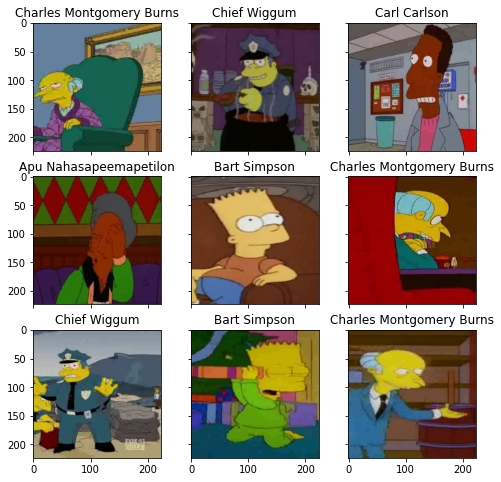

In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (8, 8), \
                       sharey = True, sharex = True)
i = 0
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    
    #im_val, label = test_train_dataset[i]
    #i+=1
    im_val, label = test_eval_dataset[random_characters]
    
    img_label = " ".join(map(lambda x: x.capitalize(),\
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

In [ ]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    train_epoch_losses = []


    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_epoch_losses.append(loss)
        #print('batch_loss:', loss)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc, train_epoch_losses

In [ ]:
def fit_eval(model, val_loader, criterion):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    eval_epoch_losses = []
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            #print('batch_loss:', loss)
            eval_epoch_losses.append(loss)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    
    val_loss = running_loss / processed_data
    val_acc = running_corrects.cpu().numpy() / processed_data
    return val_loss, val_acc, eval_epoch_losses

In [ ]:
def train(train_loader, val_loader, model, criterion, epochs, opt, scheduler):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    since = time.time()
    train_losses = []
    val_losses = []
    with tqdm(desc='Epoch', total=epochs) as pbar_outer:
        #opt = torch.optim.AdamW(model.parameters())
        #criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc, train_epoch_losses = fit_epoch(model, train_loader, criterion, opt)
            print('\ntrain loss:', train_loss)

            val_loss, val_acc, eval_epoch_losses = fit_eval(model, val_loader, criterion)
            print('\neval loss:', val_loss)
            
            history.append((train_loss, train_acc, val_loss, val_acc))
            print(f'current learning rate: {scheduler.get_last_lr()}')
            scheduler.step()
            

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            train_losses.append(train_epoch_losses)
            val_losses.append(eval_epoch_losses)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

    return history, train_losses, val_losses

In [ ]:
def predict(model, test_loader):
    model.eval()
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            preds = model(inputs).cpu()
            logits.append(preds)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs


In [ ]:
n_classes = len(np.unique(train_val_labels))
def load_sample_1(file):
        image = Image.open(file)
        image.load()
        return image

In [ ]:
load_sample_1(sorted(train_files)[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


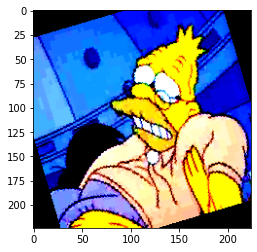

In [ ]:
tensor = train_dataset[0][0]
q = tensor.data.numpy().transpose((1, 2, 0))
plt.imshow(q)

In [ ]:
"""from torch.utils.data import WeightedRandomSampler
from collections import Counter
# write pathes to classes to list
path_to_classes = [path.parent for path in train_files]
# count files in each class
counted_files = Counter(path_to_classes)

bs = 64
per_class_weights = 1 / torch.tensor([values for _, values in sorted(counted_files.items())], dtype=torch.float64)
weighted_samples = [per_class_weights[target] for _, target in train_dataset]

sampler = WeightedRandomSampler(weighted_samples, len(weighted_samples))
train_loader = DataLoader(train_dataset, batch_size = bs, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size = bs, shuffle = False)"""

In [ ]:
bs = 16
train_loader = DataLoader(train_dataset, batch_size = bs, shuffle = True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size = bs, shuffle = False, num_workers=2)
test_train_ld = DataLoader(test_train_dataset, batch_size = bs, shuffle = True, num_workers=2)
test_eval_ld = DataLoader(test_eval_dataset, batch_size = bs, shuffle = False, num_workers=2)

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
model_name = 'efficientnet-b2'

In [ ]:
model = EfficientNet.from_pretrained(model_name)

Loaded pretrained weights for efficientnet-b2


In [ ]:
for param in model.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, n_classes)

# to GPU
model = model.to(DEVICE)

# loss
criterion = nn.CrossEntropyLoss()

# learning rate optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

# scheduler for the lr optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, 0.5)

In [ ]:
len(train_loader), len(val_loader), len(test_train_files), len(train_files)

(989, 328, 11774, 15818)

In [ ]:
import time
history_feature_extr, train_losses, val_losses = train(test_train_ld, test_eval_ld, model=model, criterion=criterion, opt=optimizer, epochs=5, scheduler=scheduler)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]


train loss: 0.3158772688254057


Epoch:  20%|██        | 1/5 [05:25<21:41, 325.39s/it]


eval loss: 7.130949753238686
current learning rate: [0.0005]

Epoch 001 train_loss: 0.3159     val_loss 7.1309 train_acc 0.9173 val_acc 0.4836


In [ ]:
arr = np.zeros(2, dtype=int)
for input, target in trainLoader:
    arr[target] += 1

In [ ]:
for inputs, targets in train_loader:
    print(targets)

In [ ]:
history = train(test_train_ld, test_eval_ld, model=simple_cnn, epochs=5)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]


loss 2.787171121373949


Epoch:  20%|██        | 1/5 [02:34<10:18, 154.59s/it]


Epoch 001 train_loss: 2.7872     val_loss 2.1946 train_acc 0.2421 val_acc 0.4155

loss 1.8569719840217425


Epoch:  40%|████      | 2/5 [05:09<07:44, 154.78s/it]


Epoch 002 train_loss: 1.8570     val_loss 1.6501 train_acc 0.4867 val_acc 0.5439

loss 1.4184555907015302


Epoch:  60%|██████    | 3/5 [07:44<05:09, 154.90s/it]


Epoch 003 train_loss: 1.4185     val_loss 1.2772 train_acc 0.6058 val_acc 0.6592

loss 1.1605611871072345


Epoch:  80%|████████  | 4/5 [10:19<02:35, 155.01s/it]


Epoch 004 train_loss: 1.1606     val_loss 1.0973 train_acc 0.6825 val_acc 0.7019

loss 0.9890215086692925


Epoch: 100%|██████████| 5/5 [12:54<00:00, 154.97s/it]


Epoch 005 train_loss: 0.9890     val_loss 1.0357 train_acc 0.7244 val_acc 0.7275


In [ ]:
history = train(train_loader, val_loader, model=simple_cnn, epochs=8)

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



loss 2.9589923305718226


Epoch:  12%|█▎        | 1/8 [05:16<36:58, 316.98s/it]


Epoch 001 train_loss: 2.9590     val_loss 2.4569 train_acc 0.2019 val_acc 0.3444

loss 2.1289113649740328


Epoch:  25%|██▌       | 2/8 [10:31<31:33, 315.58s/it]


Epoch 002 train_loss: 2.1289     val_loss 1.6721 train_acc 0.4269 val_acc 0.5493

loss 1.5936891962038386


Epoch:  38%|███▊      | 3/8 [15:46<26:15, 315.18s/it]


Epoch 003 train_loss: 1.5937     val_loss 1.3247 train_acc 0.5660 val_acc 0.6500

loss 1.3253877823833153


Epoch:  50%|█████     | 4/8 [21:02<21:02, 315.59s/it]


Epoch 004 train_loss: 1.3254     val_loss 1.1999 train_acc 0.6389 val_acc 0.6799

loss 1.1775341306201532


Epoch:  62%|██████▎   | 5/8 [26:19<15:47, 315.94s/it]


Epoch 005 train_loss: 1.1775     val_loss 1.1064 train_acc 0.6776 val_acc 0.6984

loss 1.0647159636566026


Epoch:  75%|███████▌  | 6/8 [31:37<10:33, 316.89s/it]


Epoch 006 train_loss: 1.0647     val_loss 0.9991 train_acc 0.7124 val_acc 0.7299

loss 0.9779785604172357


Epoch:  88%|████████▊ | 7/8 [36:54<05:16, 316.85s/it]


Epoch 007 train_loss: 0.9780     val_loss 0.9048 train_acc 0.7327 val_acc 0.7544

loss 0.9081832665067098


Epoch: 100%|██████████| 8/8 [42:09<00:00, 316.23s/it]


Epoch 008 train_loss: 0.9082     val_loss 0.8624 train_acc 0.7505 val_acc 0.7698


In [ ]:
list(WeightedRandomSampler([0.1, 0.9, 0.4, 0.7, 3.0, 0.6], 5, replacement=True))loss, acc, val_loss, val_acc = zip(*history)

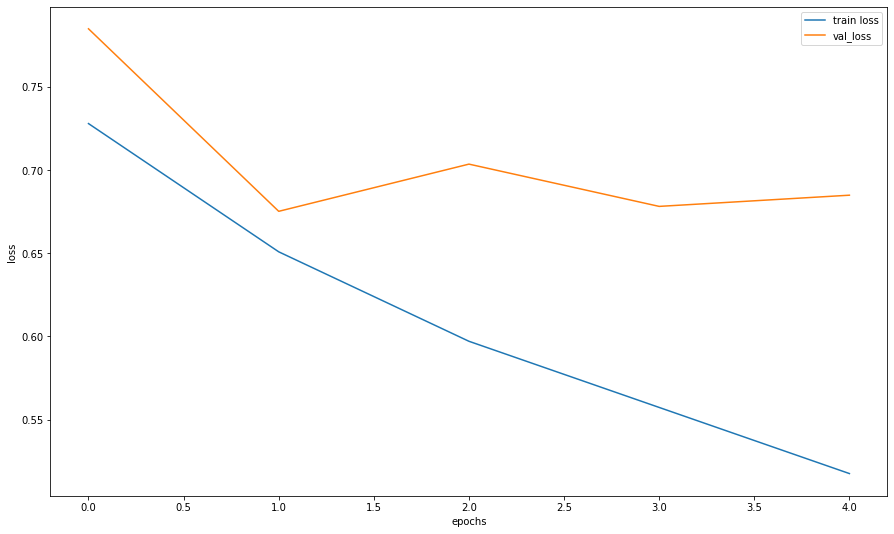

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='val_loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

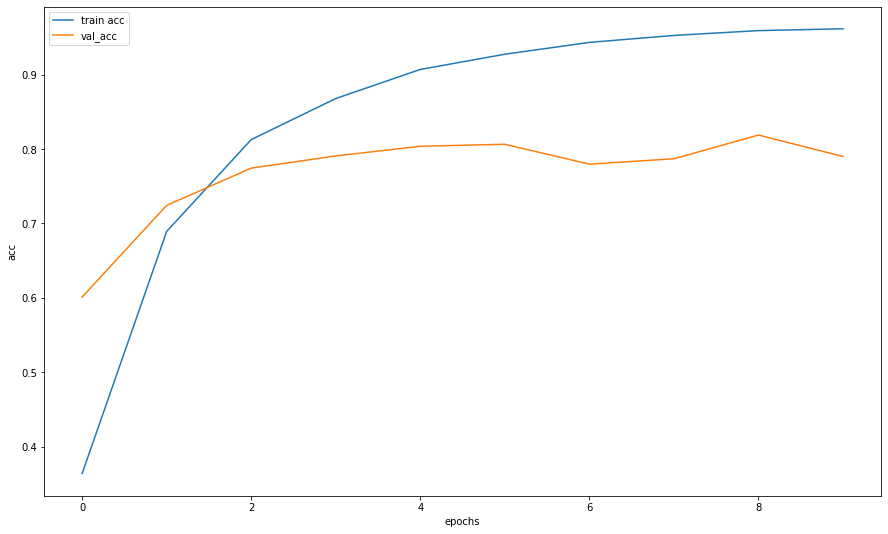

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label='train acc')
plt.plot(val_acc, label='val_acc')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    model.eval()
    with torch.no_grad():
        inputs = inputs.to(DEVICE)
        out = model(inputs).cpu()
        preds = nn.functional.softmax(out, dim=-1).numpy()
    return preds

In [ ]:
random_characters = int(np.random.uniform(0, 1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
actual_labels = [val_dataset[id][1] for id in idxs]
actual_labels

[6, 0, 0, 0, 6, 6, 2, 4, 5, 0, 6, 4, 2, 2, 6, 4, 6, 4, 5, 0]

In [ ]:
y_pred = np.argmax(probs_ims, -1)
y_pred

array([27,  0,  0,  0,  6,  6,  2,  4,  5,  0,  6,  4,  9,  2,  6,  4,  6,
        4, 17,  0])

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='weighted')

0.9093939393939394

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
actual_class = [label_encoder.classes_[i] for i in actual_labels]
actual_class

['charles_montgomery_burns',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'charles_montgomery_burns',
 'charles_montgomery_burns',
 'apu_nahasapeemapetilon',
 'bart_simpson',
 'carl_carlson',
 'abraham_grampa_simpson',
 'charles_montgomery_burns',
 'bart_simpson',
 'apu_nahasapeemapetilon',
 'apu_nahasapeemapetilon',
 'charles_montgomery_burns',
 'bart_simpson',
 'charles_montgomery_burns',
 'bart_simpson',
 'carl_carlson',
 'abraham_grampa_simpson']

In [ ]:
preds_class = [label_encoder.classes_[i] for i in y_pred]
preds_class

['moe_szyslak',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'charles_montgomery_burns',
 'charles_montgomery_burns',
 'apu_nahasapeemapetilon',
 'bart_simpson',
 'carl_carlson',
 'abraham_grampa_simpson',
 'charles_montgomery_burns',
 'bart_simpson',
 'comic_book_guy',
 'apu_nahasapeemapetilon',
 'charles_montgomery_burns',
 'bart_simpson',
 'charles_montgomery_burns',
 'bart_simpson',
 'krusty_the_clown',
 'abraham_grampa_simpson']

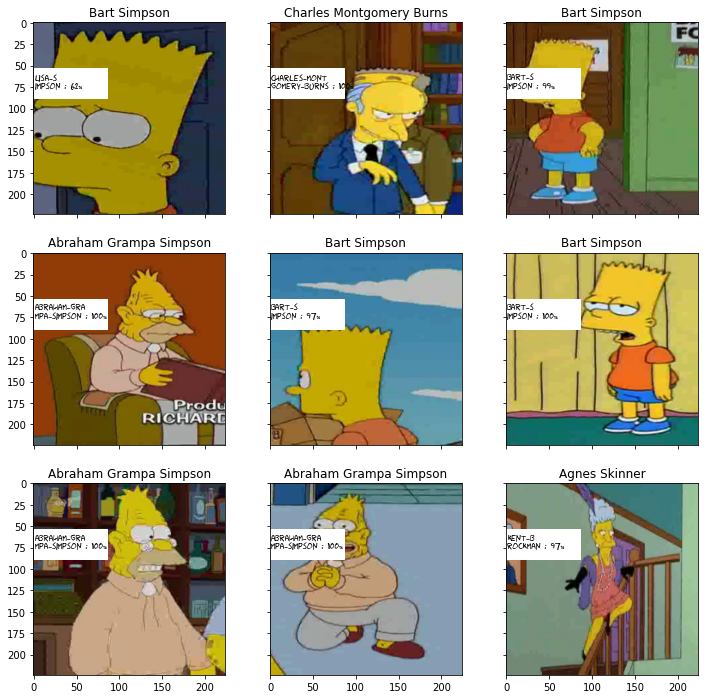

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')